# Start kit for Task 1 - Sleep stage decoding transfer learning challenge

We recommand you to read the 'LeaderboardDataGuide' and visit the https://beetl.ai to get familar with data and tasks before you read this start kit.

## Objective of the tutorial

In this start kit, we used 10 example subjects from Physionet Sleep Cassette Data to show an example pipeline of the challenge including:

- Environment Setup
- Sleep Data loading
- Source and target domain data organisation
- Training and evaluation procedure using an example shallow CNN.

References:

> Schirrmeister, Robin Tibor, et al. "Deep learning with convolutional neural networks for EEG decoding and visualization." Human brain mapping 38.11 (2017): 5391-5420.

> Braindecode https://braindecode.org 

> dl-eeg-tutorial https://github.com/hubertjb/dl-eeg-tutorial

> Physionet Sleep Cassette Data https://physionet.org/content/sleep-edfx/1.0.0/


## Environment Setup

In [1]:
# !pip install torch
# !pip install mne
# !pip install matplotlib
# !pip install scikit-learn
# !pip install pandas
# !pip install braindecode
# !pip install moabb

Import packages and set ramdom SEED. 

**Important** For participants, please MAKE SURE that your model and uploaded labels are reproducable. We will run winner's code and generate the label to compare with the uploaded labels.

In [2]:
# import sys
# sys.path.append('../')
from util.preproc import plot_confusion_matrix
import matplotlib.pyplot as plt 
import torch
import numpy as np
from numpy.random import RandomState
import pickle

cuda = torch.cuda.is_available()
print('gpu condition: ', cuda)
device = 'cuda' if cuda else 'cpu'

SEED=42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
rng = RandomState(SEED)

gpu condition:  True


## Loading Sleep Data

Assume source group is subject 0-4, target group is subject 5-7, and subject 8,9 are from target group for testing. 

Loading source data and sample subject from target group, here we just train source and target together as an example, without using more complex transfer learning methods. Please come up with your own approach.

Please read the DataGuide kit and refer to our data downloading guide [package](https://github.com/sylvchev/beetl-competition) to download the data example data in this tutorial.

In [3]:
from beetl.task_sleep import BeetlSleepDataset
ds = BeetlSleepDataset()
path = ds.download()

In [4]:
savebase = path+'\\'
print(savebase)

with open (savebase+"headerInfo.npy", 'rb') as fp:
        info = pickle.load(fp)
# print(info)

for i_train in range(5):
    print('subject ',i_train)
    with open (savebase+"s"+str(i_train)+"r1X.npy", 'rb') as fp:
        X0 = pickle.load(fp)
    with open (savebase+"s"+str(i_train)+"r1y.npy", 'rb') as fp:
        y0 = pickle.load(fp)
    print(y0.shape,X0.shape)
    if i_train==0:
        X_train = X0
        y_train = y0
    else:
        X_train = np.concatenate((X_train,X0))
        y_train = np.concatenate((y_train,y0))
print('overall source size')
print(y_train.shape,X_train.shape)

for i_target in range(5,7):
    print('subject ',i_target)
    with open (savebase+"s"+str(i_train)+"r1X.npy", 'rb') as fp:
        X0 = pickle.load(fp)
    with open (savebase+"s"+str(i_train)+"r1y.npy", 'rb') as fp:
        y0 = pickle.load(fp)
    print(y0.shape,X0.shape)
    X_train = np.concatenate((X_train,X0))
    y_train = np.concatenate((y_train,y0))
print('overall source and target size')
print(y_train.shape,X_train.shape)

C:\Users\asus\mne_data\MNE-beetlsleep-data\
subject  0
(836,) (836, 2, 3000)
subject  1
(1087,) (1087, 2, 3000)
subject  2
(1020,) (1020, 2, 3000)
subject  3
(950,) (950, 2, 3000)
subject  4
(1234,) (1234, 2, 3000)
overall source size
(5127,) (5127, 2, 3000)
subject  5
(1234,) (1234, 2, 3000)
subject  6
(1234,) (1234, 2, 3000)
overall source and target size
(7595,) (7595, 2, 3000)


**Among target subject 5,6,7 , subject 7 is used as validation. Note data are not normalized, and labled are not balenced. Please come up with your strategy.**

In [5]:
i_val=7
with open (savebase+"s"+str(i_val)+"r1X.npy", 'rb') as fp:
        X_val = pickle.load(fp)
with open (savebase+"s"+str(i_val)+"r1y.npy", 'rb') as fp:
        y_val = pickle.load(fp)
print('validation size')
print(y_val.shape,X_val.shape)

for i_test in range(8,10):
    print('subject ',i_test)
    with open (savebase+"s"+str(i_test)+"r1X.npy", 'rb') as fp:
        X0 = pickle.load(fp)
    with open (savebase+"s"+str(i_test)+"r1y.npy", 'rb') as fp:
        y0 = pickle.load(fp)
    print(y0.shape,X0.shape)
    if i_test==8:
        X_test = X0
        y_test = y0
    else:
        X_test = np.concatenate((X_test,X0))
        y_test = np.concatenate((y_test,y0))
print('overall test size')
print(y_test.shape,X_test.shape)

validation size
(969,) (969, 2, 3000)
subject  8
(1127,) (1127, 2, 3000)
subject  9
(1130,) (1130, 2, 3000)
overall test size
(2257,) (2257, 2, 3000)


**Start training procedure, used a shallow CNN structure as an example, you should replace it with your own algorithm here**

In [6]:
class TrainObject(object):
    def __init__(self, X, y):
        assert len(X) == len(y)
        mean=np.mean(X,axis=2,keepdims=True)
        #here normalise across the window, when channel size is not large enough
        #In motor imagery kit, we put axis = 1, across channel as an example
        std=np.std(X,axis=2,keepdims=True)
        X=(X-mean)/(std)
        #we scale it to 1000 as a better training scale of the shallow CNN
        #according to the orignal work of the paper referenced above
        self.X = X.astype(np.float32)*1e3
        self.y = y.astype(np.int64)
train_set = TrainObject(X_train, y=y_train)
valid_set = TrainObject(X_val, y=y_val)
test_set = TrainObject(X_test, y=y_test)
# print(train_set.X[1,:,:20])

In [7]:
from torch import nn
from braindecode.util import set_random_seeds
import util.shallow_net
from util.utilfunc import get_balanced_batches
print(cuda)
set_random_seeds(seed=42, cuda=cuda)
input_time_length = X_train.shape[2]
print(input_time_length)
in_chans=X_train.shape[1]
model = util.shallow_net.EEGShallowClassifier(in_chans, 6, input_time_length, return_feature=False)
if cuda:
    model.cuda()

True
3000
feature shape is:  (1, 40, 194, 1)
feature reduction shape is:  (1, 50, 1, 1)


In [8]:
from torch import optim
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.5*0.001)
totol_epoch=-1
Tlosses=[]
Taccuracies=[]
Vlosses=[]
Vaccuracies=[]
highest_acc=0

Epoch 0
Train  Loss: 0.63963
Train  Accuracy: 76.9%
Valid  Loss: 1.16556
Valid  Accuracy: 57.9%
model saved
[[114   3   0   0   0   0]
 [ 57  17   5   0   0  10]
 [ 61  20 266   9   5  42]
 [ 17   0   5  42  11   5]
 [  2   0   0  34  46   0]
 [ 86  28   8   0   0  76]]
Normalized confusion matrix


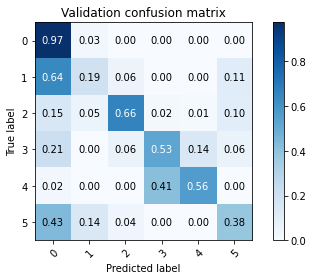

Epoch 1
Train  Loss: 0.48858
Train  Accuracy: 82.1%
Valid  Loss: 1.18238
Valid  Accuracy: 56.3%
Epoch 2
Train  Loss: 0.43222
Train  Accuracy: 84.0%
Valid  Loss: 0.94904
Valid  Accuracy: 65.8%
model saved
[[115   2   0   0   0   0]
 [ 48  24  13   0   0   4]
 [ 26  19 347   3   0   8]
 [  7   5  26  35   5   2]
 [  2   0   1  35  44   0]
 [ 80  36   9   0   0  73]]
Normalized confusion matrix


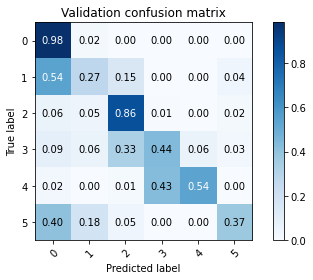

Epoch 3
Train  Loss: 0.35393
Train  Accuracy: 88.0%
Valid  Loss: 0.99585
Valid  Accuracy: 66.9%
model saved
[[115   2   0   0   0   0]
 [ 53  23  10   1   0   2]
 [ 50  15 303  20   0  15]
 [ 10   1   9  54   6   0]
 [  1   0   0  24  57   0]
 [ 80  19   3   0   0  96]]
Normalized confusion matrix


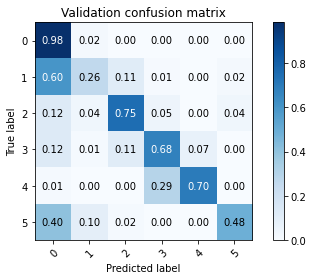

Epoch 4
Train  Loss: 0.35497
Train  Accuracy: 87.4%
Valid  Loss: 1.24307
Valid  Accuracy: 59.0%
Epoch 5
Train  Loss: 0.32891
Train  Accuracy: 89.4%
Valid  Loss: 1.21149
Valid  Accuracy: 61.2%
Epoch 6
Train  Loss: 0.31440
Train  Accuracy: 89.2%
Valid  Loss: 1.41649
Valid  Accuracy: 58.5%
Epoch 7
Train  Loss: 0.29476
Train  Accuracy: 89.9%
Valid  Loss: 1.44769
Valid  Accuracy: 57.5%
Epoch 8
Train  Loss: 0.23806
Train  Accuracy: 92.6%
Valid  Loss: 1.07375
Valid  Accuracy: 66.4%
Epoch 9
Train  Loss: 0.28499
Train  Accuracy: 90.3%
Valid  Loss: 1.28013
Valid  Accuracy: 62.6%
time is  60.03978872299194


In [9]:
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
rng = RandomState(SEED)
from braindecode.util import np_to_var, var_to_np
import torch.nn.functional as F
import time

start=time.time()
batch_size=60
for i_epoch in range(10):
    
    totol_epoch+=1
    #Randomize batches ids and get iterater 'i_trials_in_batch'
    i_trials_in_batch = get_balanced_batches(len(train_set.X), rng, shuffle=True,
                                            batch_size=batch_size)
    # Set model to training mode
    model.train()
    for i_trials in i_trials_in_batch:
        # Have to add empty fourth dimension to X for training
        batch_X = train_set.X[i_trials][:,:,:,None]
        batch_y = train_set.y[i_trials]
        #convert from nparray to torch tensor
        net_in = np_to_var(batch_X)
        if cuda:
            net_in = net_in.cuda()
        net_target = np_to_var(batch_y)
        if cuda:
            net_target = net_target.cuda()
        # Remove gradients of last backward pass from all parameters
        optimizer.zero_grad()
        # Compute outputs of the network
        outputs = model(net_in)
        # Compute the loss
        loss = F.nll_loss(outputs, net_target)
        # Do the backpropagation
        loss.backward()
        # Update parameters with the optimizer
        optimizer.step()
    # Set model to evaluation mode
    model.eval()
    print("Epoch {:d}".format(totol_epoch))
    average_acc=[]
    average_loss=[]
    
    #here we compute training accuracy and validation accuracy of current model
    for setname, dataset in (('Train', train_set), ('Valid', valid_set)):
        i_trials_in_batch = get_balanced_batches(len(dataset.X), rng, shuffle=False,
                                            batch_size=60)
        outputs=None
        for i_trials in i_trials_in_batch:
            batch_X = dataset.X[i_trials][:,:,:,None]
            batch_y = dataset.y[i_trials]
            net_in = np_to_var(batch_X)
            if cuda:
                net_in = net_in.cuda()
            toutputs = model(net_in)
            if outputs is None:
                temp=toutputs.cpu()
                outputs=temp.detach().numpy()
            else:
                temp=toutputs.cpu()
                outputs=np.concatenate((outputs,temp.detach().numpy()))
        net_target=np_to_var(dataset.y)
        loss = F.nll_loss(torch.from_numpy(outputs), net_target)
        print("{:6s} Loss: {:.5f}".format(
            setname, float(var_to_np(loss))))
        predicted_labels = np.argmax((outputs), axis=1)
        accuracy = np.mean(dataset.y  == predicted_labels)
        
        print("{:6s} Accuracy: {:.1f}%".format(
            setname, accuracy * 100))
#         print(predicted_labels)
        if setname == 'Train':
            Tlosses.append(loss)
            Taccuracies.append(accuracy)
            current_Tacc=accuracy
        elif setname == 'Valid':
            Vlosses.append(loss)
            Vaccuracies.append(accuracy)
            if accuracy>=highest_acc:
                savename='D:\\sleep'+'\\cnn_model_sleep.pth'
                
                torch.save({
                    'in_chans': in_chans,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'n_classes': 6,
                    'input_time_length':input_time_length
                }, savename)

                highest_acc=accuracy
                print('model saved')
                plot_confusion_matrix(dataset.y, predicted_labels, classes=['0','1','2','3','4','5'], normalize=True,
                      title='Validation confusion matrix')
                plt.show()
        else:
            average_acc.append(accuracy)
            average_loss.append(accuracy)
end=time.time()

print('time is ', end-start)

**Plot training and validation curve, model was saved according to validation accuracy**

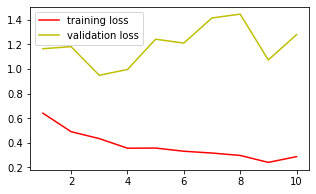

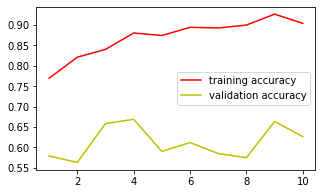

In [10]:
%matplotlib inline 
plt.rcParams['figure.figsize'] = (5.0, 3.0)
t = np.arange(0.0, len(Tlosses), 1)+1
plt.plot(t,Tlosses,'r',t,Vlosses,'y')
plt.legend(('training loss', 'validation loss'))
plt.show()
plt.plot(t,Taccuracies,'r',t,Vaccuracies,'y')
plt.legend(('training accuracy', 'validation accuracy'))
plt.show()

**Load the saved model make prediction on the subjects from new target group**

feature shape is:  (1, 40, 194, 1)
feature reduction shape is:  (1, 50, 1, 1)
testset Loss: 0.72814
testset Accuracy: 73.9%
[[414  49   0   0   0   1]
 [ 21  43  11   3   0   9]
 [ 12  20 712  50   0  29]
 [  2   3  82 139  17   2]
 [  1   0   4  94 176   0]
 [  0  14 150  13   1 185]]
Normalized confusion matrix


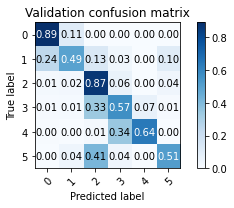

In [12]:
from braindecode.util import np_to_var, var_to_np
import torch.nn.functional as F

model = util.shallow_net.EEGShallowClassifier(in_chans, 6, input_time_length, return_feature=False)
if cuda:
    model.cuda()
checkpoint = torch.load('D:\\sleep'+'\\cnn_model_sleep.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

average_acc=[]
average_loss=[]
setname='testset'
dataset=test_set

i_trials_in_batch = get_balanced_batches(len(dataset.X), rng, shuffle=False,
                                    batch_size=30)
outputs=None
for i_trials in i_trials_in_batch:
    # Have to add empty fourth dimension to X
#             print(i_trials)
    batch_X = dataset.X[i_trials][:,:,:,None]
    batch_y = dataset.y[i_trials]
    net_in = np_to_var(batch_X)
    if cuda:
        net_in = net_in.cuda()
    toutputs = model(net_in)
    if outputs is None:
        temp=toutputs.cpu()
        outputs=temp.detach().numpy()
    else:
        temp=toutputs.cpu()
        outputs=np.concatenate((outputs,temp.detach().numpy()))
net_target=np_to_var(dataset.y)
#         print(outputs)
#         if cuda:
#             net_target = net_target.cuda()
#         print(outputs)
loss = F.nll_loss(torch.from_numpy(outputs), net_target)
print("{:6s} Loss: {:.5f}".format(
    setname, float(var_to_np(loss))))
predicted_labels = np.argmax((outputs), axis=1)
accuracy = np.mean(dataset.y  == predicted_labels)

print("{:6s} Accuracy: {:.1f}%".format(
    setname, accuracy * 100))
plot_confusion_matrix(dataset.y, predicted_labels, classes=['0','1','2','3','4','5'], normalize=True,
                  title='Validation confusion matrix')
plt.show()